In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
import glob

# Fonction de réduction de mémoire
def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'object':
            num_unique_values = df[col].nunique()
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

# Dossier du dataset
dataset_path = "/kaggle/input/nbaiot-dataset"
all_files = glob.glob(os.path.join(dataset_path, "*.csv"))

dfs = []

for file_path in all_files:
    print(f"📥 Traitement de : {file_path}")
    
    try:
        df = pd.read_csv(file_path)

        filename = os.path.basename(file_path).lower()

        if "benign" in filename:
            label = "benign"
        elif "gafgyt" in filename:
            label = "gafgyt"
        elif "mirai" in filename:
            label = "mirai"
        else:
            print(f"🚫 Fichier ignoré (type d'attaque inconnu) : {filename}")
            continue

        df["label"] = label

        # Réduction mémoire dès le chargement
        df = reduce_memory(df)

        dfs.append(df)

        # Libération de mémoire
        del df
        gc.collect()

    except Exception as e:
        print(f"🚫 Erreur lors de la lecture de {file_path} : {e}")

# Fusion des DataFrames
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    full_df = reduce_memory(full_df)  # Juste au cas où
    print("✅ Données combinées avec succès.")
    print(full_df["label"].value_counts())

    # Optionnel : enregistrer le DataFrame pour recharger sans retraiter
    full_df.to_parquet("full_df.parquet", index=False)

    # Libération mémoire des df intermédiaires
    del dfs
    gc.collect()

else:
    print("❌ Aucune donnée chargée.")


📥 Traitement de : /kaggle/input/nbaiot-dataset/7.gafgyt.combo.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/9.gafgyt.combo.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/5.gafgyt.combo.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/1.mirai.udp.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/4.gafgyt.udp.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/6.gafgyt.udp.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/6.gafgyt.junk.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/data_summary.csv
🚫 Fichier ignoré (type d'attaque inconnu) : data_summary.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/5.gafgyt.udp.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/9.gafgyt.junk.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/9.mirai.scan.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/1.benign.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/2.mirai.udpplain.csv
📥 Traitement de : /kaggle/input/nbaiot-dataset/3.gafgyt.combo.csv
📥 Traitement de : /kaggle/input/nb

In [4]:
print(full_df.isnull().sum())



MI_dir_L5_weight         0
MI_dir_L5_mean           0
MI_dir_L5_variance       0
MI_dir_L3_weight         0
MI_dir_L3_mean           0
                        ..
HpHp_L0.01_magnitude     0
HpHp_L0.01_radius        0
HpHp_L0.01_covariance    0
HpHp_L0.01_pcc           0
label                    0
Length: 116, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


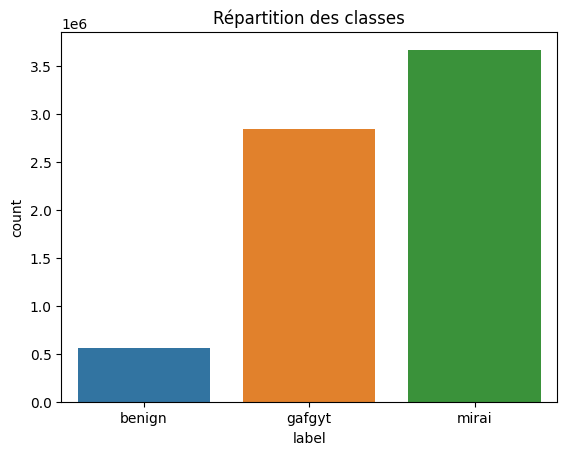

In [5]:
sns.countplot(data=full_df, x="label")
plt.title("Répartition des classes")
plt.show()


In [6]:
print(full_df.describe())


       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      7.062606e+06    7.062606e+06        7.062606e+06      7.062606e+06   
mean       8.168002e+01    1.787253e+02        1.546414e+04      1.292258e+02   
std        6.828133e+01    1.668922e+02        2.442233e+04      1.092890e+02   
min        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
25%        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
50%        9.133941e+01    7.400975e+01        5.630810e+00      1.405521e+02   
75%        1.415606e+02    3.140587e+02        3.351639e+04      2.262886e+02   
max        4.380028e+02    1.452697e+03        4.918058e+05      5.586770e+02   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    7.062606e+06        7.062606e+06      7.062606e+06    7.062606e+06   
mean     1.788192e+02        1.715113e+04      3.670795e+02    1.790749e+02   
std      1.615682e+02        2.49

In [7]:
X = full_df.drop("label", axis=1)
y = full_df["label"]


In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [11]:
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 📉 Réduction de la taille du dataset pour ménager la RAM
sample_size = 100_000  # Ajuste si besoin (plus petit si crash)
df_sampled = full_df.sample(n=sample_size, random_state=42)

# Séparation des features et de la cible
X = df_sampled.drop("label", axis=1)
y = df_sampled["label"]

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split entraînement/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Libération mémoire
del df_sampled, X, y
gc.collect()


0

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def evaluer_modele(nom, modele):
    modele.fit(X_train, y_train)
    y_pred = modele.predict(X_test)

    print(f"\n📊 Résultats pour {nom} :")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluer_modele("Random Forest", rf_model)

# 2. SVM linéaire (plus léger en mémoire)
svm_model = SVC(kernel='linear', random_state=42)
evaluer_modele("SVM (linéaire)", svm_model)

# 3. Régression Logistique
lr_model = LogisticRegression(max_iter=1000)
evaluer_modele("Régression Logistique", lr_model)



📊 Résultats pour Random Forest :
[[ 1544     0     0]
 [    2  8031     0]
 [    0     0 10423]]
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      1544
      gafgyt       1.00      1.00      1.00      8033
       mirai       1.00      1.00      1.00     10423

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


📊 Résultats pour SVM (linéaire) :
[[ 1538     6     0]
 [    6  8025     2]
 [    0    14 10409]]
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      1544
      gafgyt       1.00      1.00      1.00      8033
       mirai       1.00      1.00      1.00     10423

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


📊 Résultats pour Régression Logistique :

In [13]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=5,  # réduit pour limiter l’usage mémoire
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Résultats optimisés
print("✅ Meilleurs paramètres :")
print(random_search.best_params_)

y_pred_opt = random_search.best_estimator_.predict(X_test)
print("\n🎯 Rapport optimisé :")
print(classification_report(y_test, y_pred_opt, target_names=label_encoder.classes_))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Meilleurs paramètres :
{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}

🎯 Rapport optimisé :
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      1544
      gafgyt       1.00      1.00      1.00      8033
       mirai       1.00      1.00      1.00     10423

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



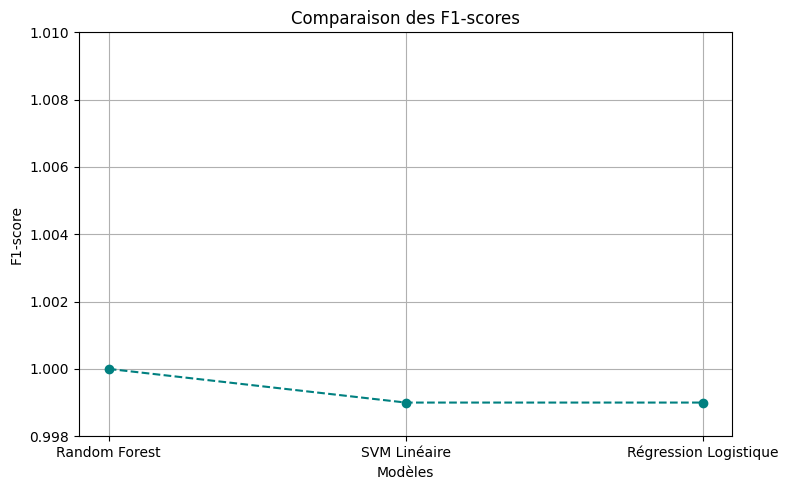

In [14]:
import matplotlib.pyplot as plt

# F1-scores par classe et modèle (extrait de ton rapport)
models = ['Random Forest', 'SVM Linéaire', 'Régression Logistique']
f1_scores = [1.00, 0.999, 0.999]

# Tracé de la courbe
plt.figure(figsize=(8, 5))
plt.plot(models, f1_scores, marker='o', linestyle='--', color='teal')
plt.title("Comparaison des F1-scores")
plt.xlabel("Modèles")
plt.ylabel("F1-score")
plt.ylim(0.998, 1.01)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Création du modèle
rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, random_state=42)

# Entraînement
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=42)

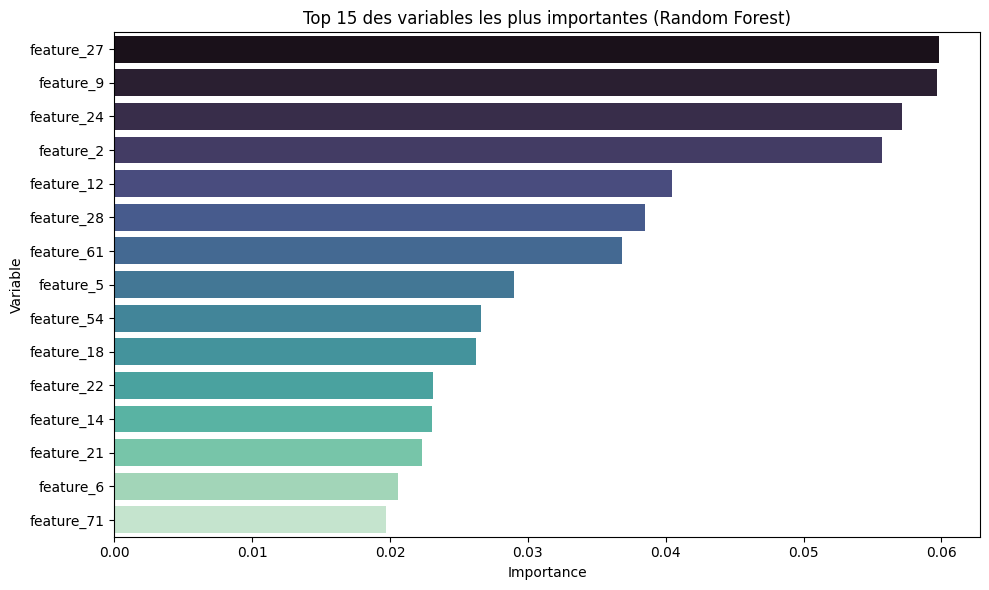

In [18]:
importances = rf.feature_importances_

# Utilise le vrai nom des colonnes si tu les as :
# feature_names = df.drop('label', axis=1).columns

# Sinon, génère des noms génériques :
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Création d’un DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage des 15 plus importantes
top_features = feat_imp_df.head(15)

# Tracé
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='mako')
plt.title("Top 15 des variables les plus importantes (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


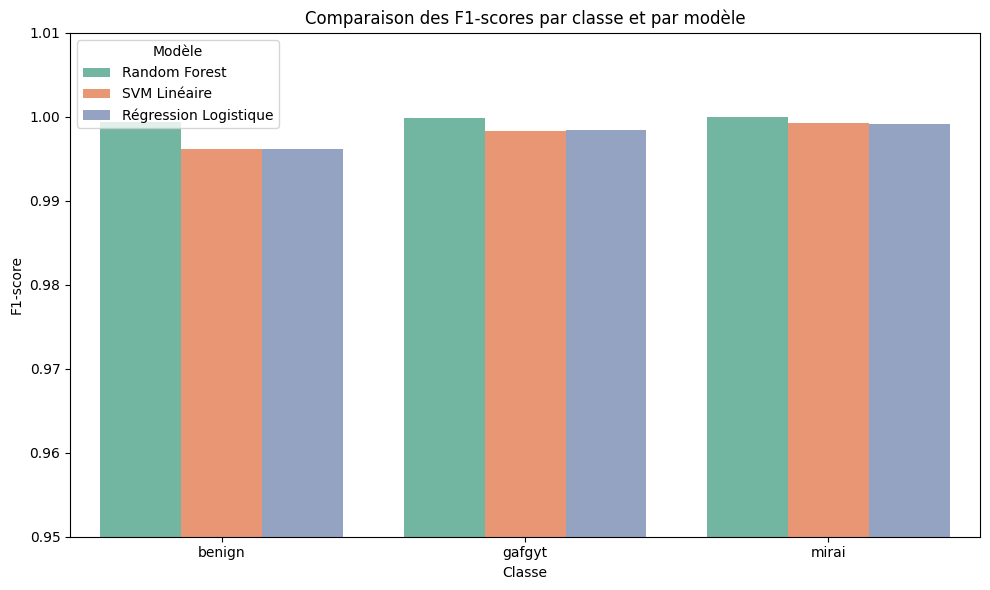

In [19]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supposons que tu as ces vraies étiquettes
y_true = y_test  # ou remplace selon ton code

# Prédictions de chaque modèle
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

# Calcul des F1-scores par classe
f1_rf = f1_score(y_true, y_pred_rf, average=None)
f1_svm = f1_score(y_true, y_pred_svm, average=None)
f1_lr = f1_score(y_true, y_pred_lr, average=None)

# Préparation des données
model_names = ['Random Forest', 'SVM Linéaire', 'Régression Logistique']
classes = ['benign', 'gafgyt', 'mirai']

df_f1 = pd.DataFrame({
    'Classe': classes * 3,
    'F1-score': list(f1_rf) + list(f1_svm) + list(f1_lr),
    'Modèle': [model_names[0]] * 3 + [model_names[1]] * 3 + [model_names[2]] * 3
})

# Tracé de la courbe
plt.figure(figsize=(10, 6))
sns.barplot(data=df_f1, x='Classe', y='F1-score', hue='Modèle', palette='Set2')
plt.title("Comparaison des F1-scores par classe et par modèle")
plt.ylim(0.95, 1.01)  # Optionnel si les scores sont très proches de 1
plt.ylabel("F1-score")
plt.xlabel("Classe")
plt.legend(title="Modèle")
plt.tight_layout()
plt.show()
